# SentencePiece 토크나이저 실습하기

## 데이터 살펴보기

In [73]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [75]:
import os
path_to_file = '/content/drive/MyDrive' +'/aiffel/sp_tokenizer/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


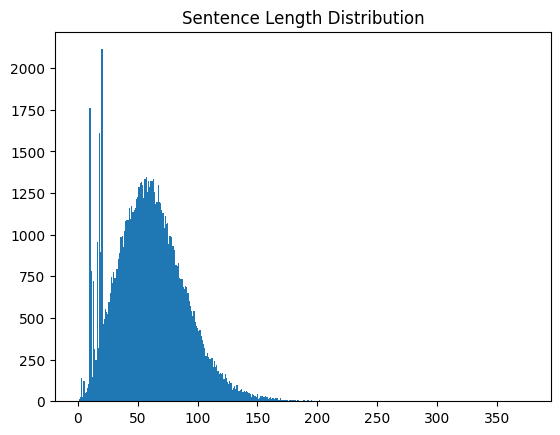

In [76]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [77]:
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


In [78]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


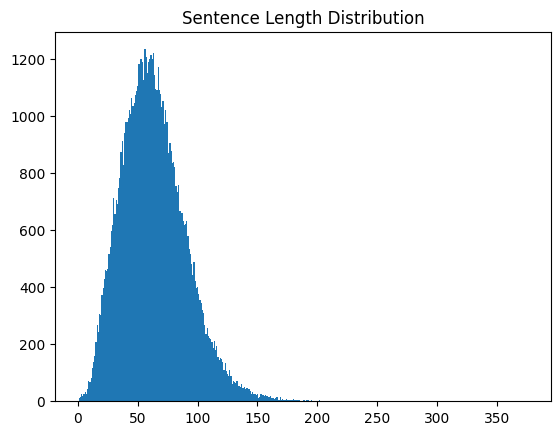

In [79]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

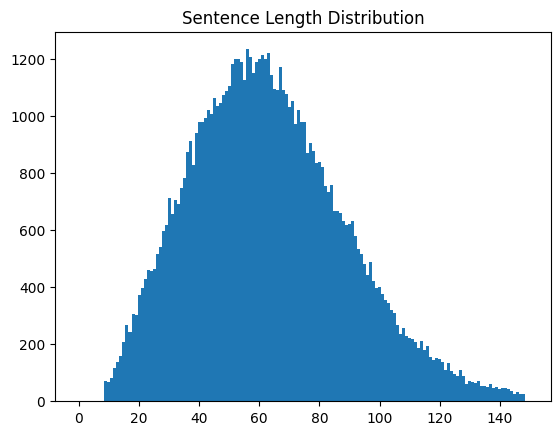

In [80]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [81]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [82]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [83]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


In [84]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

## SentencePiece 토크나이저 사용

In [109]:
import sentencepiece as spm
import os
temp_file ='/content/drive/MyDrive' +'/aiffel/sp_tokenizer/korean-english-park.train.ko.temp'

vocab_size = 24000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')


#Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.
# --model_type = bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=korean_spm --vocab_size={} '.format(temp_file, vocab_size)
)

# --model_type = unigram
# spm.SentencePieceTrainer.Train(
#     '--input={} --model_type=unigram --model_prefix=korean_spm --vocab_size={} '.format(temp_file, vocab_size)
# )

!ls -l korean_spm*

-rw-r--r-- 1 root root 683511 Feb 25 11:15 korean_spm.model
-rw-r--r-- 1 root root 410703 Feb 25 11:15 korean_spm.vocab


In [110]:
s = spm.SentencePieceProcessor()
s.Load('/content/drive/MyDrive' +'/aiffel/sp_tokenizer/korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',-1, 0.0)) # --model_type = bpe인 경우
# print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',0, 0.0)) # --model_type = unigram인 경우

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[918, 9, 989, 13, 3225, 9, 494, 41, 3]
['▁아', '버', '지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [111]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=135)

    return tensor, word_index, index_word

In [112]:
# mapper_list = []
# for text in a:
#     words = []
#     for num in text:
#         words.append(c.get(num))
#     mapper_list.append(words)
# print(mapper_list)

## SentencePiece를 감성분석에 적용해보기

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [114]:
# 전처리한 데이터를 불러온다.
train_data = pd.read_csv('/content/drive/MyDrive/aiffel/sp_tokenizer' + '/train_data_preprocessed.csv')
test_data = pd.read_csv('/content/drive/MyDrive/aiffel/sp_tokenizer' + '/test_data_preprocessed.csv')

In [115]:
# train data
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [116]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145393 entries, 0 to 145392
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145393 non-null  int64 
 1   document  145393 non-null  object
 2   label     145393 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.3+ MB


In [117]:
# test data
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
3,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
4,7898805,음악이 주가 된 최고의 음악영화,1


In [118]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48852 entries, 0 to 48851
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48852 non-null  int64 
 1   document  48852 non-null  object
 2   label     48852 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## sp tokenizer를 기반으로 리뷰 데이터를 정수 인코딩한다.

In [119]:
X_train, word_index, index_word = sp_tokenize(s, train_data['document']) # sp 토큰화
X_test, word_index, index_word = sp_tokenize(s, test_data['document']) # sp 토큰화

y_train = train_data['label']
y_test = test_data['label']

In [120]:
print(len(X_train))

145393


In [121]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145393
145393


In [122]:
X_train

array([[  350,    82,  6198, ...,     0,     0,     0],
       [13231,   885,  2886, ...,     0,     0,     0],
       [ 1070,   937,     0, ...,     0,     0,     0],
       ...,
       [   24,    85,     6, ...,     0,     0,     0],
       [ 4687,  7193,   167, ...,     0,     0,     0],
       [  126,   167,  3249, ...,     0,     0,     0]], dtype=int32)

리뷰의 최대 길이 : 135
리뷰의 평균 길이 : 135.0


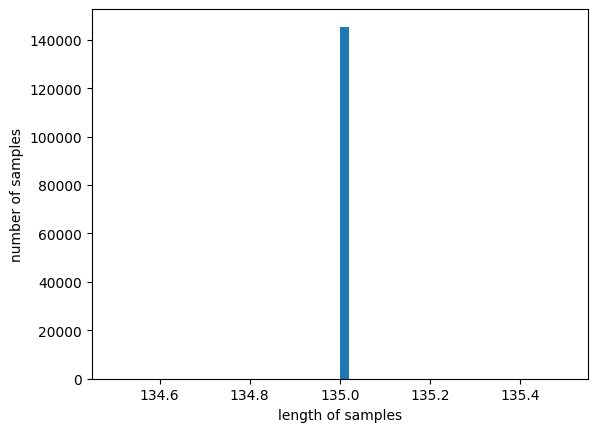

In [123]:
# 리뷰의 길이는 135이다. sp_tokenizer에서 문장을 토큰화할 때, 패딩까지 진행해주기 때문이다.

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 모델 구축하기

In [124]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
1815/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5002 - loss: 0.6934
Epoch 1: val_acc improved from -inf to 0.49555, saving model to best_model.h5


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - acc: 0.5002 - loss: 0.6934 - val_acc: 0.4955 - val_loss: 0.6932
Epoch 2/15
1815/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4981 - loss: 0.6932
Epoch 2: val_acc improved from 0.49555 to 0.50445, saving model to best_model.h5


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - acc: 0.4981 - loss: 0.6932 - val_acc: 0.5045 - val_loss: 0.6931
Epoch 3/15
1817/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5015 - loss: 0.6932
Epoch 3: val_acc did not improve from 0.50445
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - acc: 0.5015 - loss: 0.6932 - val_acc: 0.5045 - val_loss: 0.6931
Epoch 4/15
1815/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5007 - loss: 0.6932
Epoch 4: val_acc did not improve from 0.50445
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - acc: 0.5007 - loss: 0.6932 - val_acc: 0.5045 - val_loss: 0.6931
Epoch 5/15
1814/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5041 - loss: 0.6931
Epoch 5: val_acc did not improve from 0.50445
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - acc: 0.5041 - loss: 0.6931 - val_acc: 0.4955 - val_loss: 0.6932
Epoch 6/15
1817/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4985 - loss: 0.6932
Epoch 6: val_acc did not improve from 0.50445
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 21s 1

In [125]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.4967 - loss: 0.6933

 테스트 정확도: 0.4981


In [126]:
def sentiment_predict(s, new_sentence):
    tensor, _, _ = sp_tokenize(s, [new_sentence])

#     sentence = ""
#     for w in tensor:
#         if w == 0: continue
#         sentence += index_word[w] + " "

#     new_sentence = sentence
#    print(len(tensor))
#    print(tensor)
    score = float(loaded_model.predict(tensor)) # 예측

    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


In [127]:
sentiment_predict(s, '이 영화 개꿀잼 ㅋㅋㅋ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
50.51% 확률로 부정 리뷰입니다.



<ipython-input-126-ba96a20ac8dd>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(tensor)) # 예측


In [128]:
sentiment_predict(s, '기대 안하고 보러갔는데 생각보다 인상깊더라고요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
50.51% 확률로 부정 리뷰입니다.



<ipython-input-126-ba96a20ac8dd>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(tensor)) # 예측


In [129]:
sentiment_predict(s, '이 영화 핵노잼 ㅠㅠ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
50.51% 확률로 부정 리뷰입니다.



<ipython-input-126-ba96a20ac8dd>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(tensor)) # 예측


In [130]:
sentiment_predict(s, '이딴게 영화냐 ㅉㅉ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
50.51% 확률로 부정 리뷰입니다.



<ipython-input-126-ba96a20ac8dd>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(tensor)) # 예측


In [131]:
sentiment_predict(s, '감독 뭐하는 놈이냐?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
50.51% 확률로 부정 리뷰입니다.



<ipython-input-126-ba96a20ac8dd>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(tensor)) # 예측


In [132]:
sentiment_predict(s, '와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
50.51% 확률로 부정 리뷰입니다.



<ipython-input-126-ba96a20ac8dd>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(tensor)) # 예측


## 리뷰 및 회고


다음 네 가지의 경우에 대해서 실험을 진행하였을 때, 테스트 데이터에 대한 accuracy를 나타내었다.

- post-padding,	unigram 일 때: 0.4981  
- post-padding,	bpe 일 때: 0.4981
- pre-padding,	unigram 일 때: 0.8469
- pre-padding,	bpe 일 때: 0.8471

- pre 패딩을 적용할 때가 모델의 성능이 뛰어난 것을 확인할 수 있다.

- LSTM의 특성 상, 가장 나중에 들어온 정보가 최종 가중치 값에 영향을 크게 주기 때문에 pre 패딩을 사용하는 것이 적절하다고 생각한다.

```
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

```
- LMS 주피터 노트북에서 해당 코드를 실행하면 상당히 오랜 시간동안 코드가 돌아간다. 무언가 버그가 있는 것인지 모르겠다.
- 그래서 google colab 환경에서 실습을 계속 진행하였다.
